In [2]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils 

plt.style.use('ggplot')
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')
test['cardio']=-5
data = pd.concat((train,test), axis=0)

data['error_group'] = 0

# weight/height correction
idx = (data['height']<130) & (data['weight']>150)
data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<25, "weight"] += 100

    # preasure correction

data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1

original = data.copy()

data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

idx = data['ap_hi'] > 10000
data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100

data.loc[data['ap_lo'].isin([1000,1200]), 'ap_lo'] /= 10





# manual_update = [
#         (12494, ['ap_hi', 'ap_lo'], [120, 80]),
#         (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
#         (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
#         (51749, ['ap_hi', 'ap_lo'], [120, 80]),
#         (57807, ['ap_hi', 'ap_lo'], [170, 100]),
#         (60477, ['ap_hi', 'ap_lo'], [110, 80]),
#         (91198, ['ap_hi', 'ap_lo'], [100, 90]),
#         (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
#     ]
# for idx, cols, update in manual_update:
#     data.loc[data['id']==idx, cols] = update


original['error_group']=data['error_group']
# sns.lmplot(x='age', y='ap_hi', data=original, hue='error_group', fit_reg=False, size=10)
# sns.lmplot(x='age', y='ap_hi', data=data.loc[:], hue='error_group', fit_reg=False, size=10, palette=sns.color_palette("Set1", n_colors=20, desat=.5))

In [28]:
loo = pd.read_csv('LOO_results.csv', sep=',', index_col='index')
a = train.join(loo)

In [30]:
# loo['id']=loo['id'].astype('object')

a["test"] = pd.qcut(a['score'], 10, labels=False).astype('str')

0


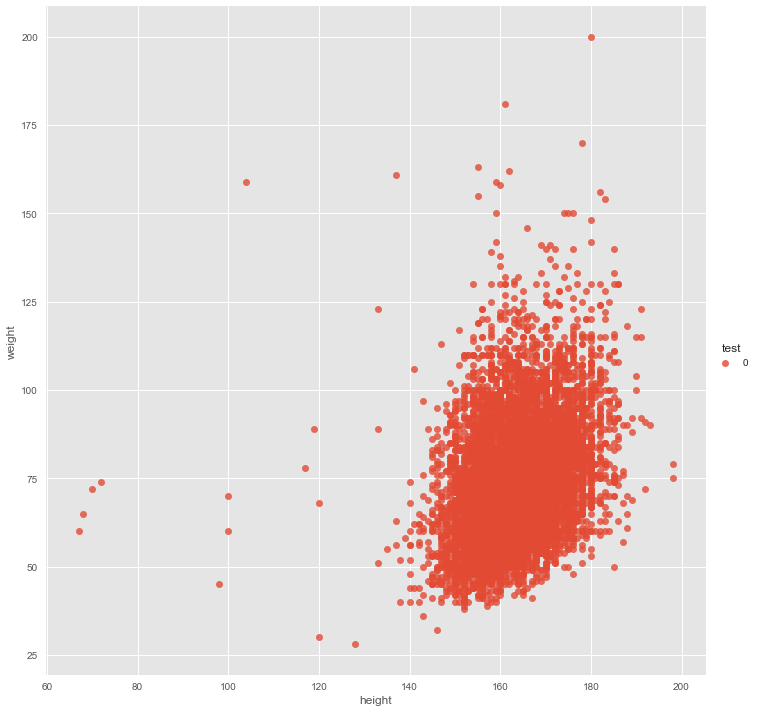

1


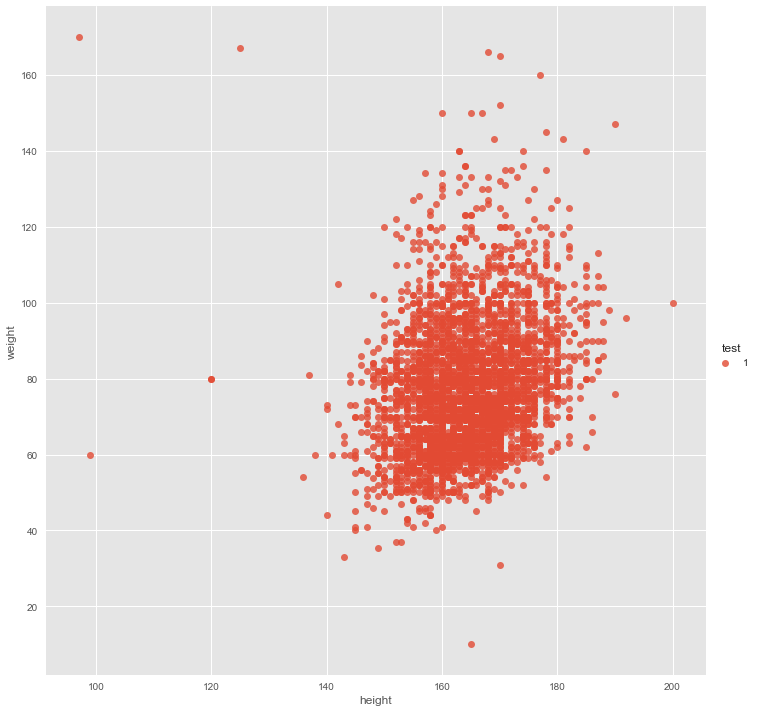

2


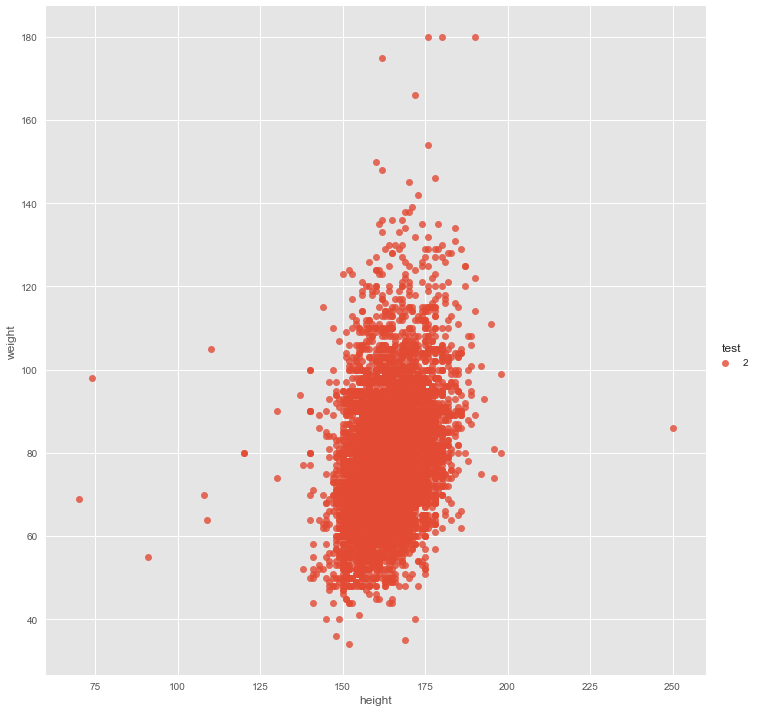

3


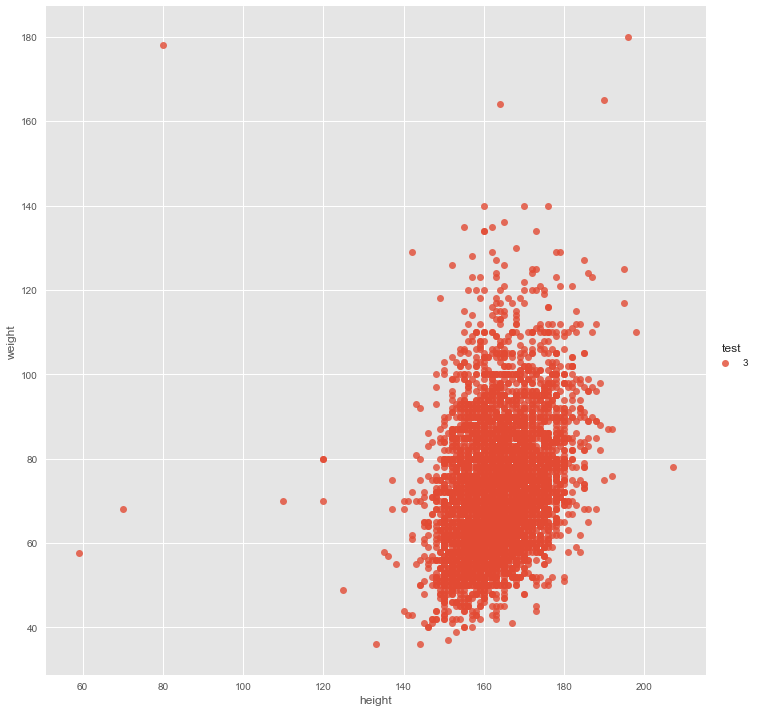

4


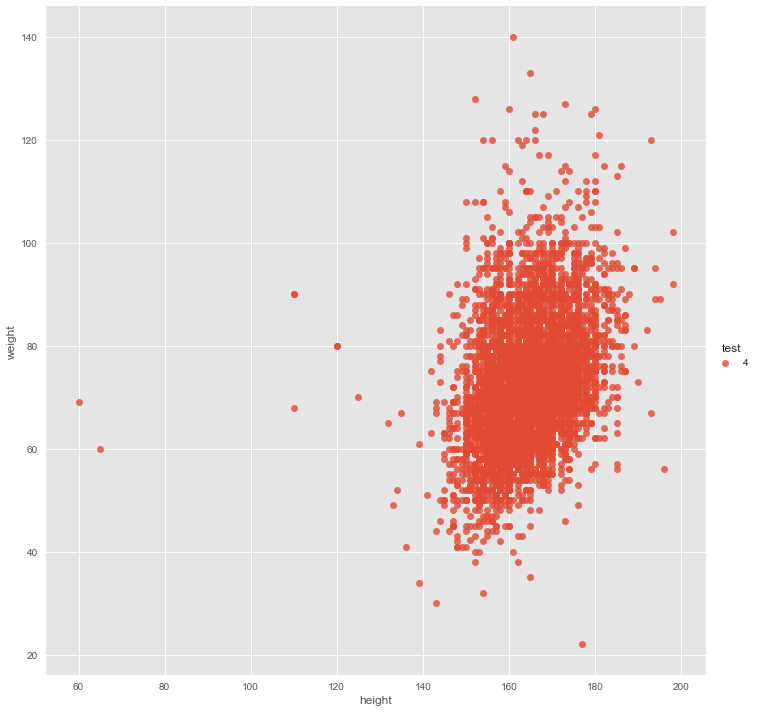

5


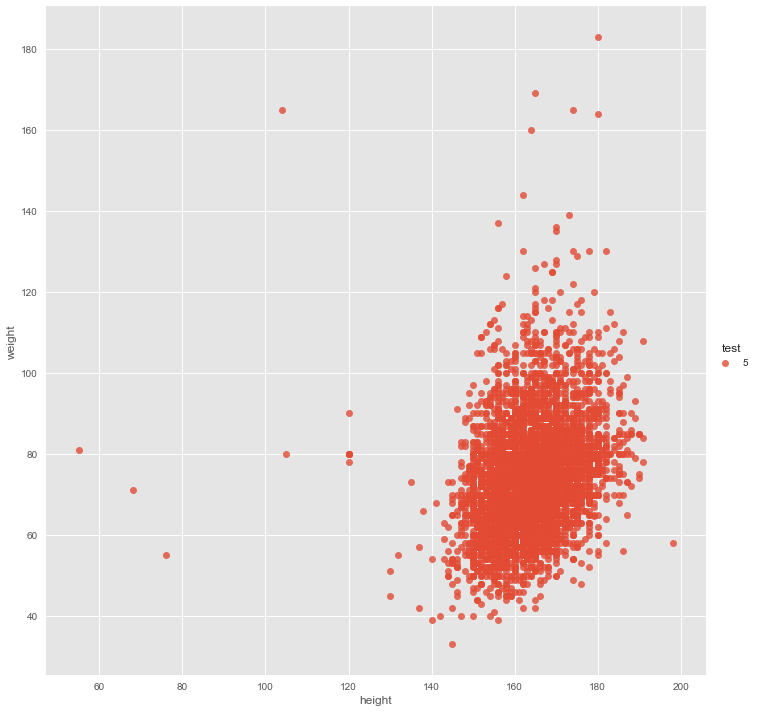

6


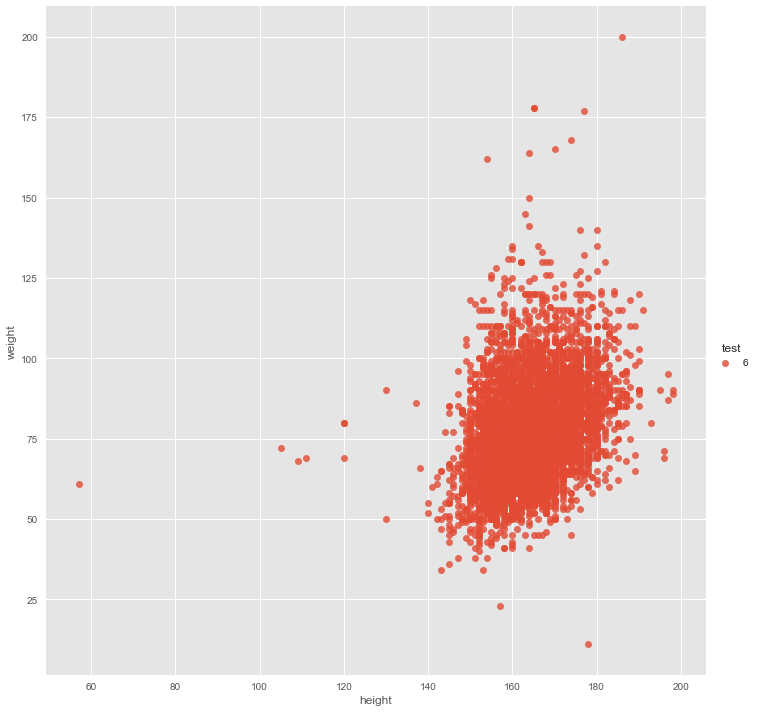

7


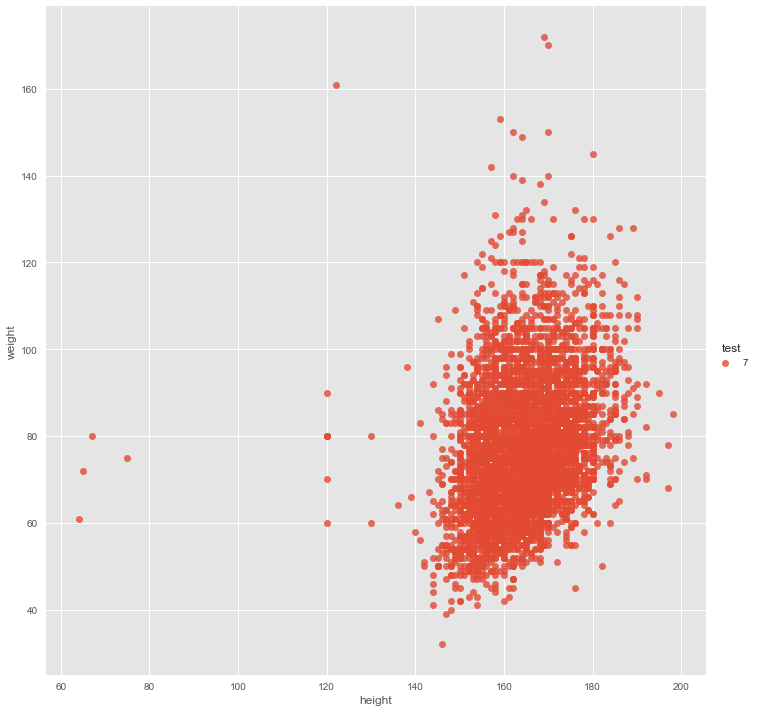

8


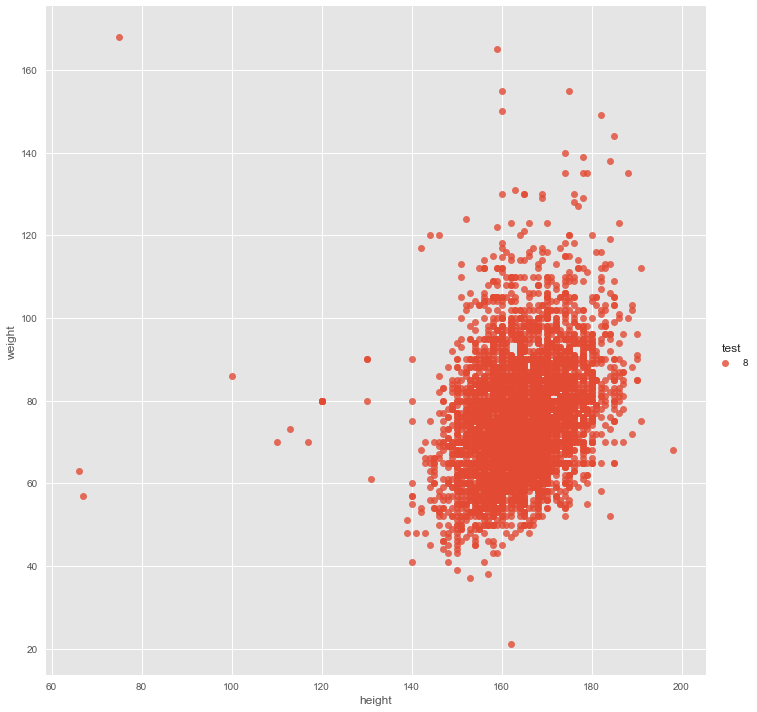

9


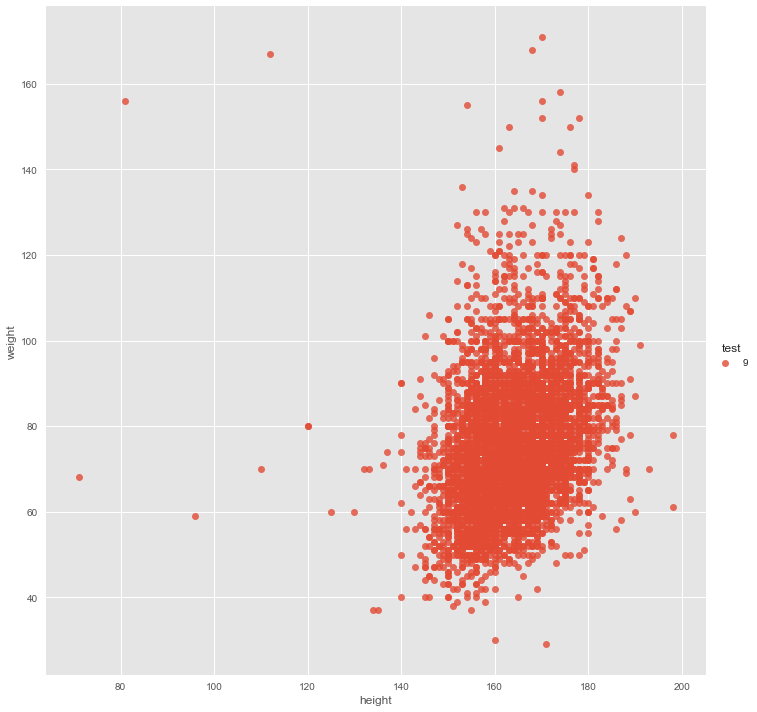

In [50]:
for i in range(10):
    print(i)
    sns.lmplot(x='height', y='weight', data=a.loc[a['test'].astype('int')==i], hue='test', fit_reg=False, size=10)
    plt.show()

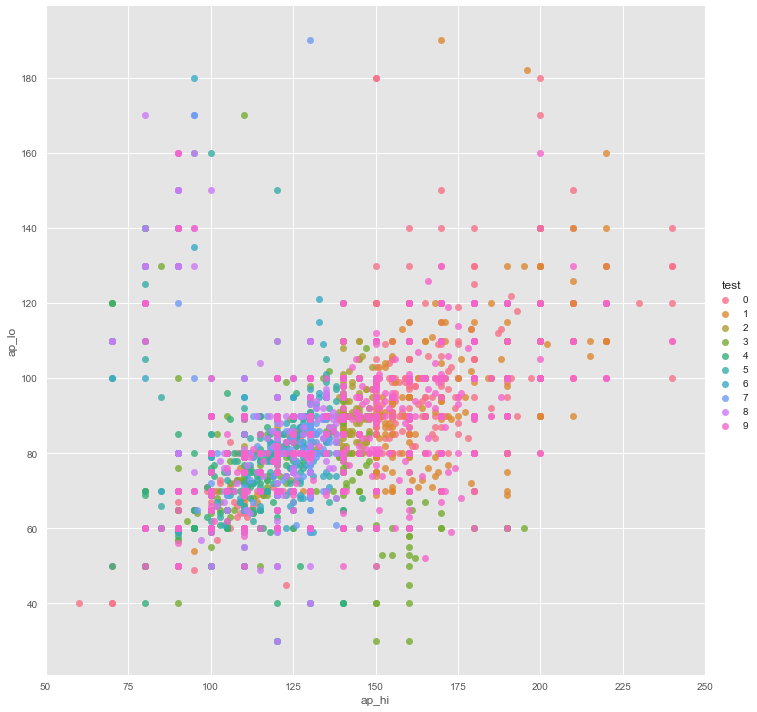

In [37]:
sns.lmplot(x='ap_hi', y='ap_lo', data=a.loc[(a['ap_hi']<250)&(a['ap_hi']>50)&(a['ap_lo']>25)&(a['ap_lo']<250)], hue='test', fit_reg=False, size=10)

0


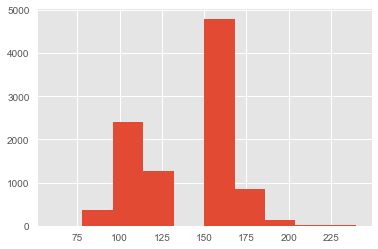

1


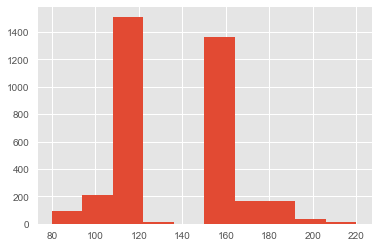

2


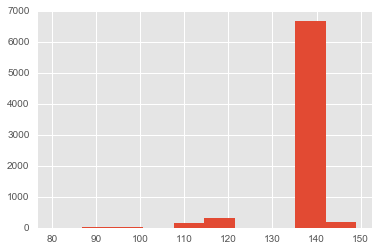

3


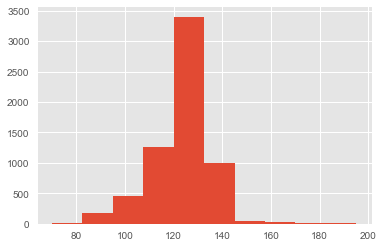

4


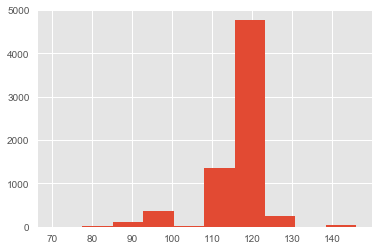

5


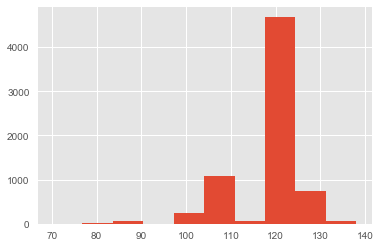

6


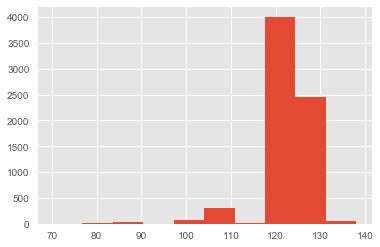

7


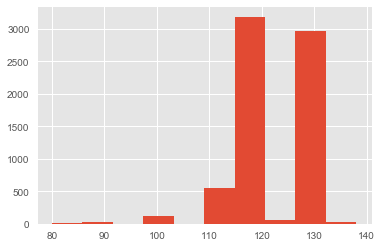

8


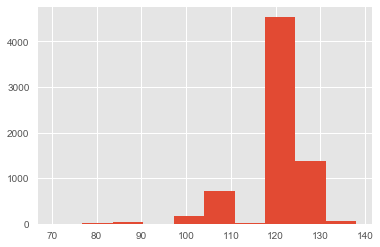

9


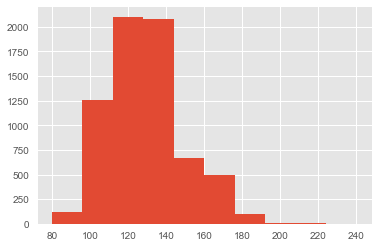

In [83]:
for i in range(10):
    print(i)
#     sns.lmplot(x='ap_hi', y='ap_lo', data=a.loc[(a['test'].astype('int')==i)&(a['ap_hi']<250)&(a['ap_hi']>50)&(a['ap_lo']>25)&(a['ap_lo']<250)], hue='test', fit_reg=False, size=10)
    a.loc[(a['test'].astype('int')==i)&(a['ap_hi']<250)&(a['ap_hi']>50)&(a['ap_lo']>25)&(a['ap_lo']<250), 'ap_hi'].hist()
    plt.show()

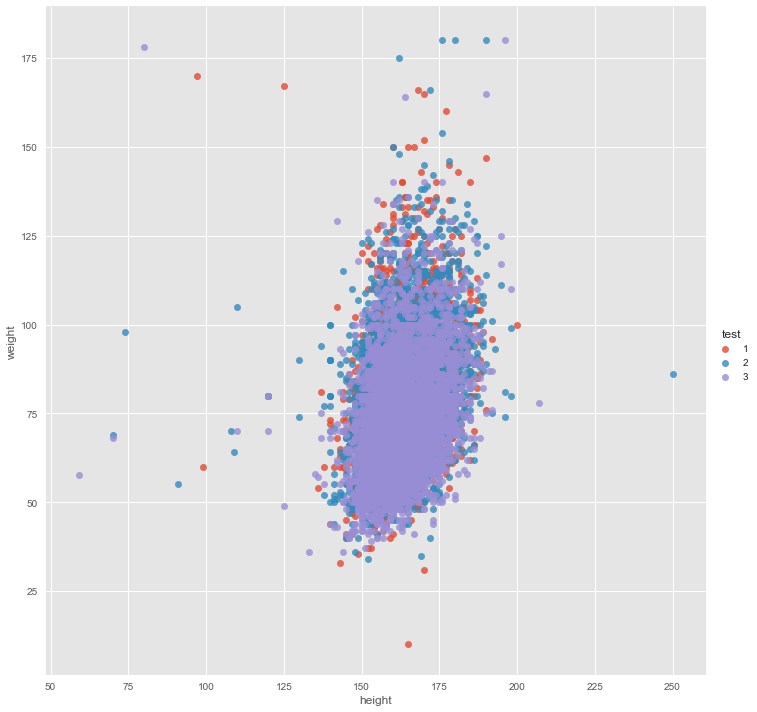

In [55]:
sns.lmplot(x='height', y='weight', data=a.loc[(a['test'].astype('int')<4)&(a['test'].astype('int')>0)], hue='test', fit_reg=False, size=10)

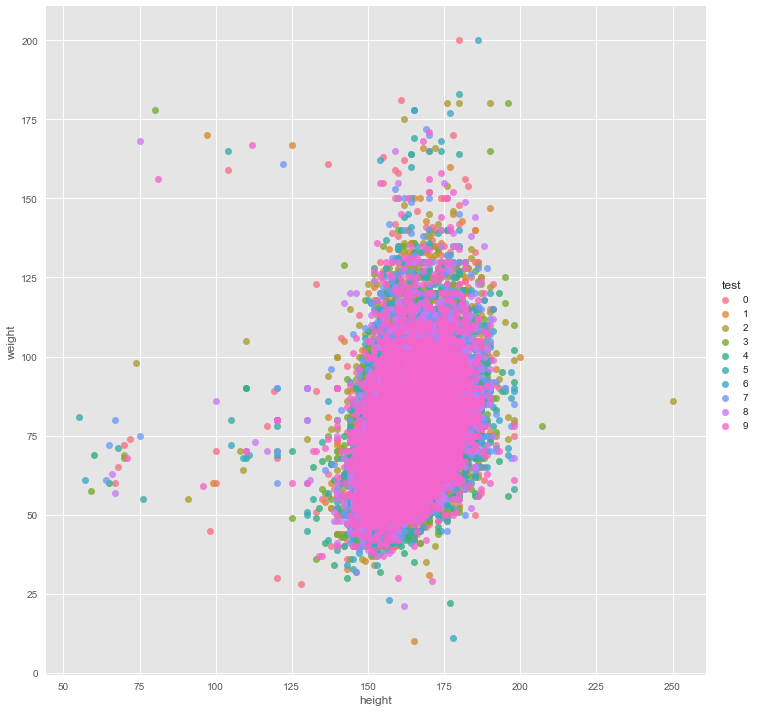

In [56]:
sns.lmplot(x='height', y='weight', data=a.loc[:], hue='test', fit_reg=False, size=10)

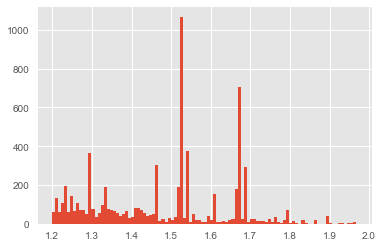

In [63]:
a.loc[a['test']=="9", 'score'].hist(bins=100)

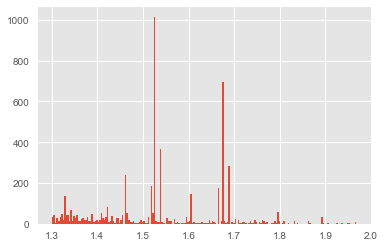

In [67]:
a.loc[a['score']>1.3, 'score'].hist(bins=200)

In [85]:
a.loc[(a['score']>1.45)&(a['score'] < 1.55), 'score'].value_counts()

1.526815    950
1.539391    339
1.461374    233
1.517886    165
1.464417     45
1.523631     37
1.526326     32
1.497218     16
1.456357     16
1.511868     14
1.526986     14
1.454766     12
1.529516     10
1.538911     10
1.501615      8
1.467386      7
1.452002      7
1.517406      6
1.454923      6
1.511730      6
1.479233      6
1.526815      5
1.521908      4
1.510904      4
1.512456      4
1.521908      4
1.526788      4
1.521965      4
1.451449      4
1.520958      3
1.519846      3
1.476069      3
1.479526      3
1.534439      3
1.454244      3
1.537194      3
1.468946      3
1.464311      3
1.478715      3
1.531711      3
1.496467      3
1.526395      3
1.462546      3
1.451424      3
1.517764      2
1.539491      2
1.530996      2
1.480956      2
1.474958      2
1.541065      2
1.467688      2
1.461230      2
1.542303      2
1.510761      2
1.531131      2
1.539464      2
1.538870      2
1.506383      2
1.509856      2
1.520481      2
1.472671      2
1.492453      2
1.500420

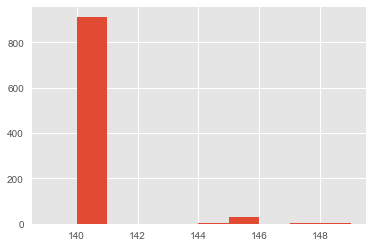

In [79]:
a.loc[np.round(a['score'],6)==1.526815, 'ap_hi'].hist()

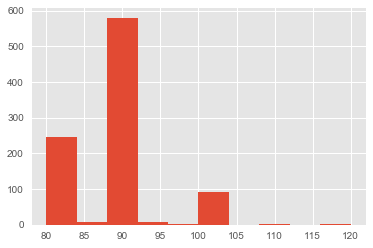

In [89]:
a.loc[(np.round(a['score'],6)==1.526815)&(a['ap_lo']<250), 'ap_lo'].hist()

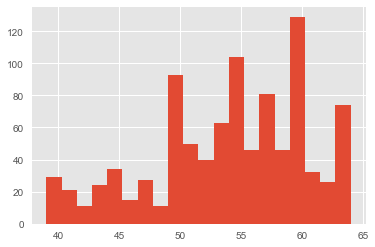

In [100]:
a['age_years'] = np.floor(a['age'] / 365)
a.loc[(np.round(a['score'],6)==1.526815), 'age_years'].hist(bins=20)

In [101]:
a.loc[(a['ap_hi']>=140)&(a['ap_hi']<150), 'cardio'].value_counts()

1    8023
0    1816
Name: cardio, dtype: int64

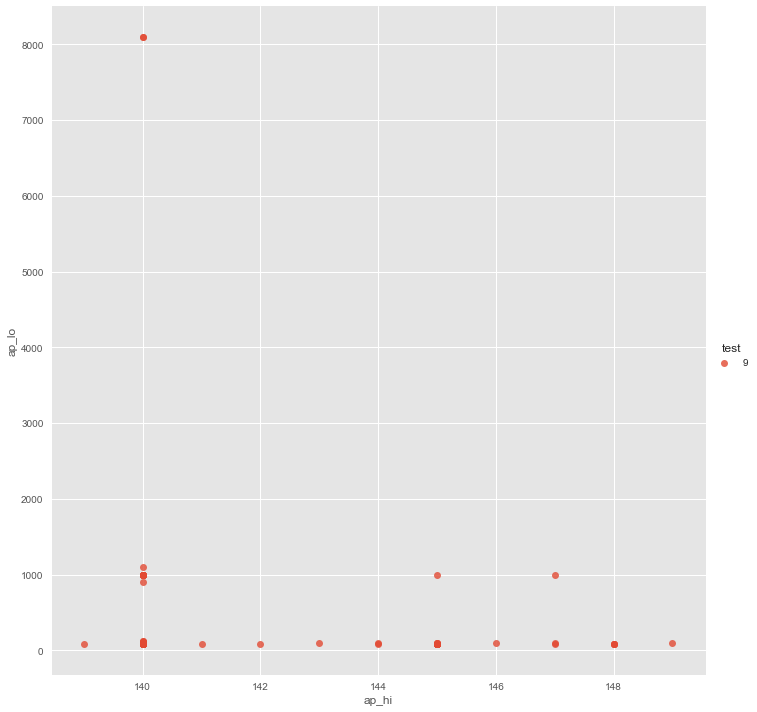

In [86]:
# a.loc[(a['ap_hi']>=140)&(a['ap_hi']<150)]

sns.lmplot(x='ap_hi', y='ap_lo', data=a.loc[np.round(a['score'],6)==1.526815], hue='test', fit_reg=False, size=10)

In [14]:
def clean_data(data):
    data['error_group'] = 0

    # weight/height correction
    idx = (data['height']<130) & (data['weight']>150)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<20, "weight"] *= 10
#     data.loc[data['weight']<25, "weight"] += 100

    # preasure correction

    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
    for i in range(10):
        str_i = str(i)
        data['hi_' + str_i + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_i))
#         data[str(i)+'lo'] = data['ap_lo'].apply(lambda x: str(x).count(str(i)))
#         data[str(i)+'hilo'] = data[str(i)+'hi']+data[str(i)+'lo']
#         data=data.drop(str(i)+'lo', axis=1)
        for j in range(10):
            str_j = str_i + str(j)
            data['hi_' + str_j + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_j))
        

#     data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
#     data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
    # data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
    # data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
    # data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
#     data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
    data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100

#     data.loc[data['ap_lo'].isin([1100])&(data['ap_hi']>160), 'ap_lo'] = 110
#     data.loc[data['ap_lo'].isin([1100]), 'ap_lo'] = 100
#     data.loc[(data['ap_lo']>250)&(data['ap_lo']<4000)&(data['ap_lo']%100==0), 'ap_lo'] /= 10
    
    manual_update = [
        
# id	age	gender	height	weight	ap_hi	ap_lo	cholesterol	gluc	smoke	alco	active	cardio	BMI
# 12494	16905	2	163	63.0	1	2088	1	1	1.0	0.0	1.0	0	23.711845
# 42591	18191	2	162	63.0	140	1900	1	1	1.0	0.0	1.0	1	24.005487
# 78873	20323	1	168	68.0	130	1900	1	1	0.0	0.0	1.0	0	24.092971
# 51749	18419	1	169	62.0	1	2088	1	1	0.0	0.0	1.0	-5	21.707923
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        
# 57807	20496	1	164	62.0	70	1100	1	1	0.0	0.0	0.0	0	23.051755
# 60477	18716	1	171	80.0	1	1088	1	1	0.0	0.0	1.0	1	27.358845
# 91198	18182	2	186	95.0	100	901	2	2	0.0	0.0	1.0	0	27.459822
# 6580	19079	1	176	92.0	1	1099	1	1	0.0	NaN	1.0	-5	29.700413
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
        
# 44701	22801	1	163	115.0	20	170	1	1	0.0	0.0	1.0	1	43.283526
# 94673	22551	1	169	88.0	10	160	3	3	0.0	0.0	0.0	1	30.811246
        (44701, ['ap_hi', 'ap_lo'], [120, 70]),
        (94673,  ['ap_hi', 'ap_lo'], [110, 60]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
        

    return data

def new_features(data):
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = (data["ap_lo"] * 2 + data["ap_dif"]) / 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 10000, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = [25, 30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names)

    return data

In [15]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

columns_to_interact = ['age_group', 'gender', 'MAP']
temp = utils.generate_interactions(X_train, columns_to_interact, 2)
X_train = pd.concat((X_train, temp), axis=1)
X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
print(temp.columns)

X = pd.concat((X_train, X_test), axis=0)

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder_dict = defaultdict(LabelEncoder)
columns_to_encode = ['age_group'] + list(temp.columns)


X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

Index(['age_group_gender', 'age_group_MAP', 'gender_MAP'], dtype='object')


In [16]:
from sklearn.model_selection import train_test_split
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=42)
X_train.loc[idx, 'alco'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=43)
X_train.loc[idx, 'smoke'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.096, random_state=44)
X_train.loc[idx, 'active'] = np.nan

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def impute_nans(model, X_train, X_test, columns, target, perform_cv = False, scoring='accuracy'):
    X = pd.concat((X_train, X_test), axis=0)
    train_idx = ~X[target].isnull()
    model = clone(model)
    model.fit(X.loc[train_idx, columns], X.loc[train_idx, target])
    X_train.loc[X_train[target].isnull(), target] = model.predict(X_train.loc[X_train[target].isnull(), columns])
    X_test.loc[X_test[target].isnull(), target] = model.predict(X_test.loc[X_test[target].isnull(), columns])
    
    if perform_cv:
        n_folds = 7
        kf = StratifiedKFold(random_state=111, n_splits=n_folds, shuffle=True)
        scores = cross_val_score(model, X.loc[train_idx, columns], X.loc[train_idx, target], cv=kf, scoring=scoring)
        print(target, np.mean(scores), 'on', n_folds, 'folds', 'with mean on train', X.loc[train_idx, target].mean())
    
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP']
impute_nans(clf, X_train, X_test, columns, 'smoke')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'alco')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'active')#, perform_cv = True)

In [11]:
bins = [0, 100,120,140,160,180,20000]
names = list(range(len(bins)-1))
a = pd.cut(X_train['ap_hi'], bins, labels=names)

# bins = [0,39, 49, 54, 59, 65]
# names = list(range(len(bins)-1))
# e = pd.cut(X_train['age_years'], bins, labels=names)

rew = (X_train['age_group'].astype('str')
    + X_train['gender'].apply(str)
    + X_train['smoke'].apply(str)
    + X_train['cholesterol'].apply(str)
#     + X_train['error_group'].apply(str)
#        + a.astype('str')
    )
rew.loc[X_train['error_group']!=0]='error' + X_train.loc[X_train['error_group']!=0, 'error_group'].astype('str')
rew.loc[X_train['age_years']<39] = 'young'

rew.loc[rew.isin((rew).value_counts()[(rew).value_counts()<10].index)] = "hacky"
# rew.value_counts()

In [12]:
# gg=X_train.copy()
# gg['cardio']=y_train
# gg.groupby('age_years')['cardio'].mean()

In [25]:
import utils
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model1",
               mean_columns = ['age_group_gender'],#, 'age_group_MAP'],#, 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10,
#               seed=150
             )

# 10 folds logloss:
# [0.5335720708196261, 0.54319126188332811, 0.54936036233309216, 0.53679379133605065, 0.53706411978818624, 0.52490119578995043, 0.54230120159481898, 0.54523086292487533, 0.53601410072526101, 0.53508468204757265]
# mean: 0.538351364924
# std: 0.00656899602179
# model1 results saved!


10 folds logloss:
[0.53381524151400073, 0.5435953036554082, 0.5495538599844404, 0.53679359901251822, 0.53666677019107467, 0.52580078941231478, 0.54289143958925512, 0.54580167565813142, 0.53605216575424564, 0.5354879854127983]
mean: 0.538645883018
std: 0.00651989188777


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000025B06519828>>
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\xgboost-0.6-py3.6.egg\xgboost\core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


15 Splits logloss:
[0.5390964173597389, 0.54280352922362785, 0.53968105038752068, 0.53380259847575662, 0.54305670748381141, 0.53300396879898826, 0.53857221447547687, 0.53419622652014775, 0.5386517371924523, 0.53884187305954956, 0.53644845799967322, 0.54278724336981143, 0.53773883644056397, 0.54000929916691109, 0.53518300326229284]
mean: 0.538258210881
std: 0.00313630605413
model1 results saved!


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000025B0EEC7E10>>
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\xgboost-0.6-py3.6.egg\xgboost\core.py", line 337, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


(0.53864588301841876, 0.53825821088108816)

In [447]:
# ids = X_train['id'].isin([12494,42591,78873,51749,57807,60477,91198,6580,])
# ids = X_train['id'].isin([2845,34120,60565,60948,92655,98095,24871,30877,88161,99929,])
ids = X_train['id'].isin([44701, 94673])

predict, _, _, _, = utils.load_model('model1')

from sklearn.metrics import log_loss
log_loss(y_train[ids], predict[ids])
# 0.92
# 0.69817735007823967

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [ ]:
10 folds logloss:
[0.53316211343285513, 0.5435962031879279, 0.54867728201528698, 0.53651873490238378, 0.53727909470172197, 0.52475207112291411, 0.54273463114564169, 0.54496225122940489, 0.53624431557193275, 0.53549874592974667]
mean: 0.538342544324
std: 0.00652689409999
15 Splits logloss:
[0.53888477666993306, 0.54218950152605772, 0.5392684533560792, 0.53284370407408765, 0.54322835531445401, 0.53276219115927792, 0.53799097376426674, 0.53380737949959212, 0.53834701399032414, 0.53868100204313374, 0.53622424516843592, 0.54254933874263722, 0.5373211861088083, 0.53968248019803311, 0.53515638711298441]
mean: 0.537929132582
std: 0.00321056488567


10 folds logloss:
[0.53340139800318942, 0.54402493769300042, 0.54889854919817616, 0.53657680791536166, 0.5376343916425822, 0.52487328929334087, 0.54225123099876382, 0.54505014110314798, 0.53629562514911466, 0.53622634612240239]
mean: 0.538523271712
std: 0.00649449868547
15 Splits logloss:
[0.53917368484789485, 0.54243159511267092, 0.53919880670322651, 0.53312569179410219, 0.54332352251426552, 0.53300622107990214, 0.53834041199188365, 0.53374835987972291, 0.53846484410674456, 0.53862878334299402, 0.53628739092451549, 0.54303022176322135, 0.53753077044533903, 0.53993105139769959, 0.5350797644216887]
mean: 0.538086741355
std: 0.00325468168847
model1 results saved!

In [74]:
pd.set_option('display.height', 1500)
pd.set_option('display.max_rows', 1500)

height has been deprecated.



D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\config.py:615: DeprecationWarning: height has been deprecated.

  warnings.warn(d.msg, DeprecationWarning)


In [23]:
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model2",
              mean_columns = ['age_group_gender', 'age_group_MAP'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53380893684715358, 0.5440990603811241, 0.54912145354792563, 0.5367423191663182, 0.53804857631691894, 0.52615442056745731, 0.54242749949993951, 0.54535151736065413, 0.53600954929377853, 0.53528736789920872]
mean: 0.538705070088
std: 0.00632731173324
15 Splits logloss:
[0.53886413006424583, 0.54252186487866927, 0.53938438332846639, 0.53326728472412865, 0.54328344078973301, 0.53336563922474378, 0.53815438107193792, 0.53390447446139389, 0.53871465667178109, 0.53927873279573235, 0.5361885557389251, 0.5428119617997913, 0.53812292555507202, 0.5399476208677868, 0.53548888327559363]
mean: 0.538219929017
std: 0.00315878684422
model2 results saved!


(0.53870507008804791, 0.53821992901653337)

In [24]:
import lightgbm as lgb
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
#     'num_leaves': 2**3,
#     'min_child_weight': 1,
    'n_estimators': 50,
    'subsample': 0.8,
#     'reg_alpha': 1.2,
#     'reg_lambda': 0.0,
       
    'nthread': 1,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(lgb.LGBMClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model3",
              mean_columns = ['age_group_gender', 'age_group_MAP'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.5333932484868591, 0.54456134266935008, 0.54913645762311025, 0.53702510917922064, 0.53852153361621935, 0.52631959739136802, 0.54226384393421889, 0.54458339599916472, 0.5353107868039364, 0.53442263921887356]
mean: 0.538553795492
std: 0.00635949865416
15 Splits logloss:
[0.53808795219816741, 0.54220858227319213, 0.53942707074498286, 0.53311932449874722, 0.54329201065613941, 0.53358879584372387, 0.53758609148925074, 0.53392404059690668, 0.53849017088090079, 0.5387554994289282, 0.53627803043941347, 0.54248773830496233, 0.53773740362423317, 0.54064212397346278, 0.53464026665810171]
mean: 0.538017673441
std: 0.00316307033079
model3 results saved!


(0.53855379549223215, 0.53801767344074092)

In [11]:
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    'tree_method': 'hist',
    'grow_policy': 'depthwise',
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="model4",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years', 'error_group'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53309790708708416, 0.54359243857297601, 0.54890140052556891, 0.53642556434372846, 0.53749371005064162, 0.52468880555427133, 0.54246732961030175, 0.54436845314766624, 0.53582375120982972, 0.53559055680787115]
mean: 0.538244991691
std: 0.00651555820791
15 Splits logloss:
[0.53857612030253121, 0.54195015569736871, 0.53886708747016854, 0.53258749437021613, 0.54311395840880761, 0.53260968033189415, 0.53785477926388647, 0.53366843150442345, 0.53826849770720664, 0.53858157204729817, 0.53568596995220708, 0.54229568004356754, 0.53723669891985093, 0.5395083833795834, 0.53503186514089707]
mean: 0.537722424969
std: 0.00321148219295
model4 results saved!


(0.53824499169099393, 0.53772242496932721)

In [ ]:
XP = X_train.copy()
XP['TARGET'] = y_train
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<300)&(XP['ap_lo']<4000)]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
# XP=XP.loc[(XP['TARGET']==0)]
# sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<=XP['ap_lo'])]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)